In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from GenDataBallDrop1 import gen_data, plot_data
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Ball Drop with Varying Radii
Consider dropping balls of various radii $R$ from a tower at heights 5, 10, 15, and 20 meters. Each dropped ball experiment produces vector output in the form of a height-time curve, i.e., a curve showing time as a function of the current height $t=t(h)$.

Rather than performing these experiments, we generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $g$ is the acceleration due to gravity, $C$ is the coefficient of drag, and R is the radius of the ball. We will refer to data generated from equation (1) as system observations. To illustrate the modeling of discrepency between simulator and reality, we will generate simulated data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\frac{dh}{dt}
\end{equation}
Note the simulated data will be systematically biased from the experimental data as it is generated with a linear velocity term $(dh/dt)$ rather than a squared velocity term. We will explicitly model this discrepecy.

These differential equations can be solved for height $h$ as a function of time $t$, ball radius $R$, and drag $C$. Observations will be the inverse: time recorded as a function of height, radius, and drag which are calculated by an optimizer from the scipy library in Python.

Acceleration due to gravity $g$ is assumed to be known, but the coefficient of drag $C$ is not, and is the target of inference. That is, the goal is to find the posterior distribution of $C$ that corresponds to the Sepia statistical model fit to all available data.

The first step is to compute system observations from (1) and simulated data from (2). As is standard practice in the study of computer codes a (space-filling) Latin hypercube (LH) design is used to efficiently collect simulator data over the domain of model parameters, in this case $(R,C)$.

Suppose we have data from $n=3$ experiments, one each for balls of radius $R={0.1,0.2,0.4}$ meters. Each experiment produces a curve of drop times made of four height-time pairs. The experimental heights are $h_e={5,10,15,20}$ meters. We assume a zero mean, normally distributed observation error $\epsilon \sim N(0,et)$ (IS THIS TRUE?). We fix $C=0.1*4\pi/3$, the coefficient of drag for a sphere, and $g=9.8 \; m/s^2$.

In [4]:
et = 0.01                      # observation error
data_dict = gen_data(et)

# field data
R = data_dict['R']             # radii of balls   .1,.2,.4 (m)
h_field = data_dict['h_field'] # observed heights 5,10,15,20 (m)
y_field = data_dict['y_field'] # observed times

generating data with C =  0.023873241463784306


For simulation design points, we use a scaled latin hypercube to select $m=25\;(R,C)$ pairs. We then scale the design so $R\in[0.05,0.45]$ to better match experimental data and $C\in[0.05,0.25]$ is chosen with some hindsight. The simulator will be run at these 25 design points and will return a time curve at 16 evenly spaced heights between 1.5 and 25 meters.

In [5]:
# sim data
sim_design = data_dict['sim_design']

# to generate a different design
#import pyDOE
#sim_design = pyDOE.lhs(2,data_dict['m'])*np.array([.4,.2])+.05
#data_dict['sim_design'] = sim_design

R_sim = sim_design[:,0]
C_sim = sim_design[:,1]
h_sim = data_dict['h_sim']
y_sim = data_dict['y_sim']

See invertH.py for details on solving and inverting equations (1) and (2) to obtain experimental and simulated data. Below we show, for each Radius R, the physical reality, defined by equation (1), the noisy observations, and all 25 simulation realizations. For each R, the 3 simulations with design points nearest to R are shown as red, green, and blue lines.

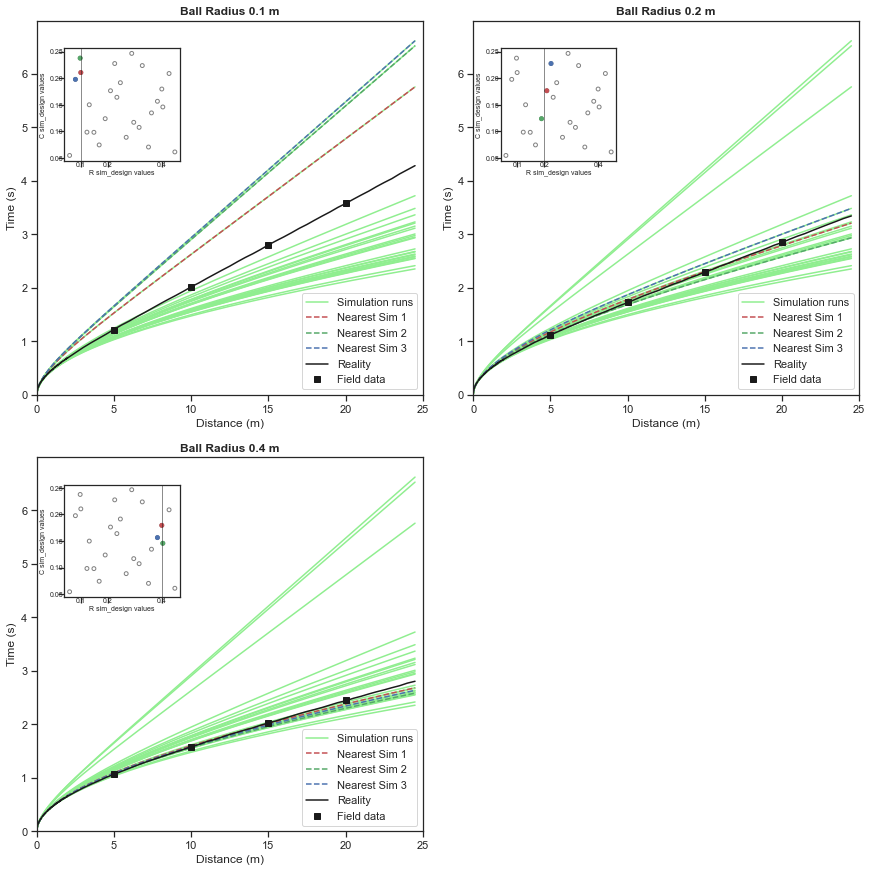

In [6]:
# see GenDataBallDrop1.py for ploting details
plot_data(data_dict)

# Preparing the data for Sepia
To use Sepia, we must package our data into a SepiaData object. In this example, the known inputs to the simulator are simply the vector of radii R_sim. We pass this into x_sim as a column vector. Similarly, C_sim is passed into t_sim as a column vector and is the parameter to be calibrated. We also pass in y_sim, the simulated time-height curves, and h_sim the heights associated with those times in y_sim. For the observed data, x_obs get the experimental radii R, and y_obs gets the experimental time-height curves generated from (1). Finally we pass in the heights at which the experimental time observations were taken, y_ind_obs = h_field.

In [7]:
data = SepiaData(x_sim = np.reshape(R_sim,(len(R_sim),1)),
                 t_sim = np.reshape(C_sim,(len(C_sim),1)), 
                 y_sim = y_sim, y_ind_sim = h_sim,
                 x_obs = np.reshape(R,(len(R),1)), y_obs = y_field, y_ind_obs=h_field)

### Transforming x, t, and y
Sepia required that the inputs $x,t$ lie in the interval $[0,1]^{p+q}$, and the responses $y_{sim},y_{obs}$ be $N(0,1)$.

In [8]:
data.transform_xt()
data.standardize_y()

### Generate K and D bases
Sepia models multivariate observations and responses using a linear basis. These *principal components*, or scaled eigenvectors, are computed by the singular value decomposition.

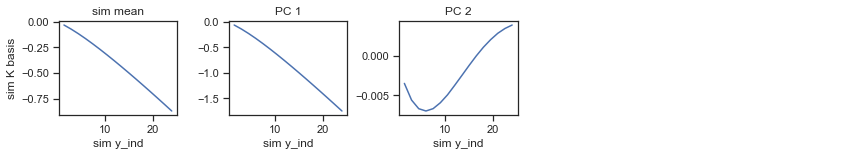

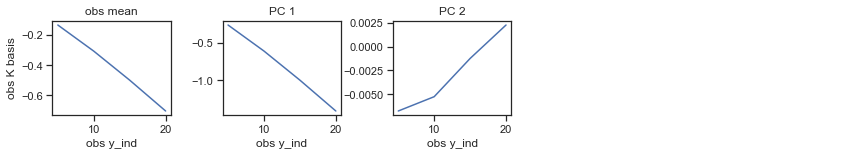

In [9]:
data.create_K_basis(2)
fig_sim, fig_obs = data.plot_K_basis()

The discrepency basis matrices D_sim and D_obs will be computed by centering normal kernels at heights h_sim and h_obs. We place normal basis kernels one standard deviation appart to ensure that no sparsity effects appear.

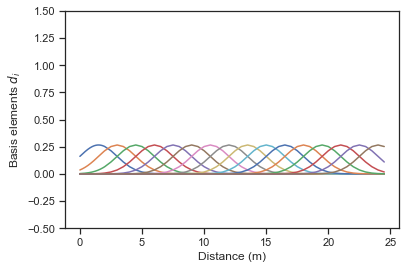

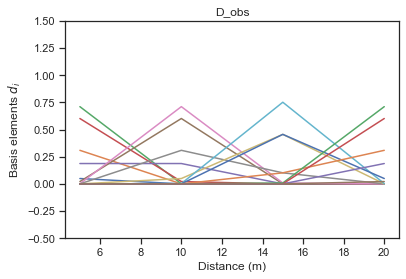

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 16, obs y dimension 4
n  =     3 (number of observed data)
m  =    25 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     2 (transformed response dimension)
pv =    16 (transformed discrepancy dimension)



In [10]:
# Generate D matrix with normal kernels
D_grid = h_sim # locations on which the kernels are centered
D_width = 1.5  # width of each kernel
pv = len(D_grid)
D_obs = np.zeros(shape=(data.obs_data.y_ind.shape[0],pv))
D_sim = np.zeros(shape=(data.sim_data.y_ind.shape[0],pv))
h_dense = data_dict['h_dense']
D_dense = np.zeros(shape=(h_dense.shape[0],pv))

for j in range(pv):
    D_obs[:,j] = norm.pdf(h_field, D_grid[j], D_width)
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)

data.create_D_basis(D_obs=D_obs.T,D_sim=D_sim)

plt.ylim(-.5,1.5)
plt.plot(h_dense,D_dense)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$")#;plt.title("D_dense (dense grid)")
plt.show()
plt.ylim(-.5,1.5)
plt.plot(h_field,D_obs)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
print(data)

We can visually check that our principal component weights are reasonable. In an ideal setting, weights would follow a standard normal distribution.

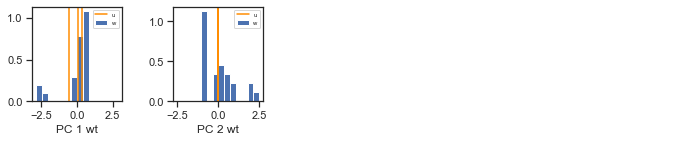

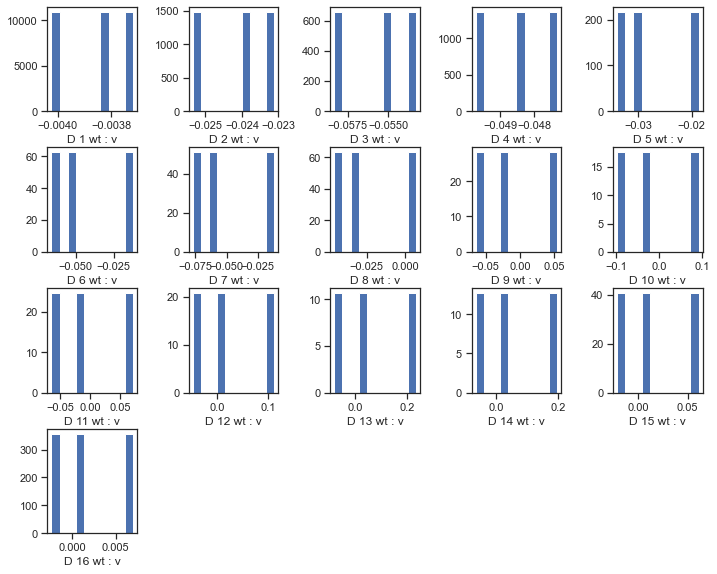

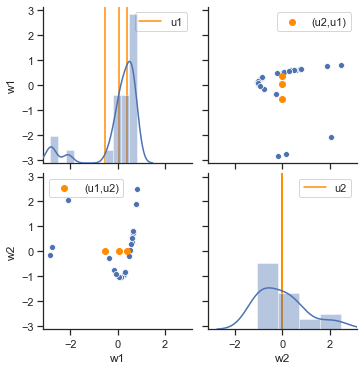

In [11]:
fig_uw, fig_v = data.plot_K_weights()
fig_uw_pairs = data.plot_u_w_pairs()

# Model initialization and MCMC
Now that our data is appropiately transformed, and out bases set, the model can be initialized and the posterior distributions of parameters sampled via Markov chain Monte Carlo (MCMC). Before performing MCMC, we call tune_step_sizes() to optimize proposal widths for each parameter.

In [12]:
override=0
cachefile_name='pkls/ball_drop_1_model.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model = SepiaModel(data)
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

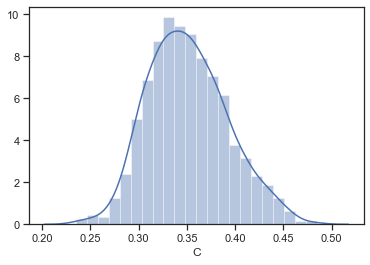

In [13]:
samples_dict = model.get_samples()
theta_names = ['C']
theta_pairs = SepiaPlot.theta_pairs(samples_dict,theta_names)

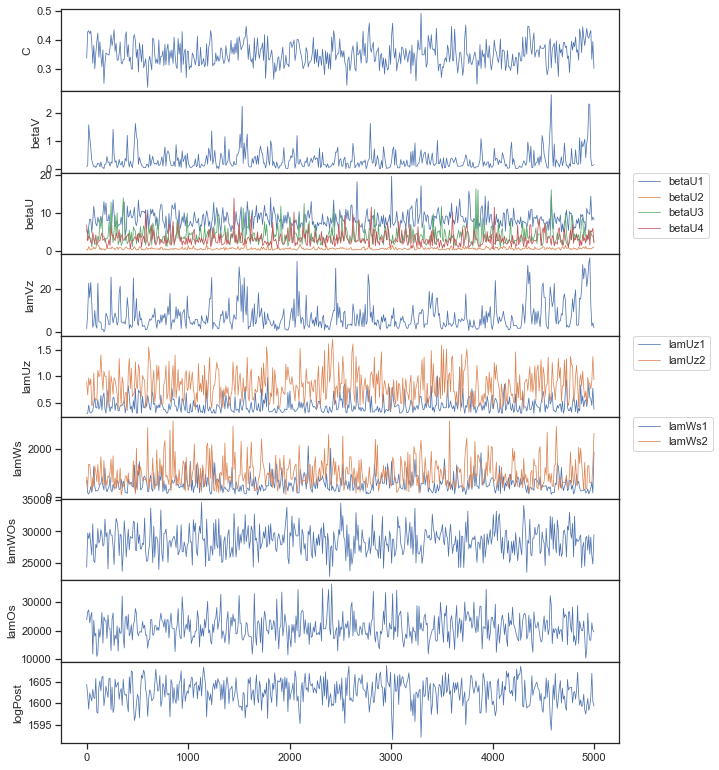

In [14]:
mcmc_trace = SepiaPlot.mcmc_trace(samples_dict,theta_names)

In [15]:
p_stats = SepiaPlot.param_stats(samples_dict,theta_names=theta_names,q1=.05,q2=.95,digits=4)
print(p_stats)

                    mean         sd  0.05 quantile  0.95 quantile
C                 0.3514     0.0408         0.2919         0.4236
betaV             0.3433     0.3782         0.0435         1.0403
betaU_1           8.5792     2.2298         5.5429        12.7958
betaU_2           0.6583     0.3205         0.2866         1.2683
betaU_3           4.2283     2.3767         1.7113         9.0153
betaU_4           3.3058     2.0100         1.1639         6.9679
lamVz             7.3923     6.4228         1.5278        21.3709
lamUz_1           0.4574     0.1375         0.3080         0.7458
lamUz_2           0.8292     0.2902         0.4356         1.3686
lamWs_1         541.9187   320.5349       163.0437      1150.3751
lamWs_2         951.2650   562.6588       256.2470      2062.8711
lamWOs        28474.0489  2119.1217     25134.4244     32089.9717
lamOs         20852.5357  4359.5514     14153.6637     28336.2918
logPost        1602.6699     2.8420      1597.5027      1606.8039
theta_nati

# Assessing emulator adequacy
It is important to examine diagnostics to understand the quality of the emulator in reproducing the simulator output at new, untried settings. The following are usful ways to asses the quality of the emulator fit.

### Principal components

### Parameters in the Gaussian Process Fit
Using the MCMC draws of the spacial dependence parameters $\beta$, $\rho=exp\{-\beta/4\}$ can be calculated to show the values on the more interpretable $[0,1]$ scale. The values of $\rho$ give us information about the dependence of the simulation output on each input parameter $x$ and $\theta$. We show boxplots of the posterior draws for $\rho$ for each $x$ and $\theta$. and for each principal component.  
When $\rho$ is near 1, it suggests that particular component of the simulator output in linear in that dimention. As $\rho$ goes smaller, nonlinear activity is associated with that input. In other words larger values of $\rho$ indicate more smoothness. Additionally, smaller values of $\rho$ indicate increasing flexibility in the model response. Very small values could indicate overfitting. Thus, if any of the boxplots show values very near to zero, the model is suspect. The boxplots below are for correlation parameters associated with the K-basis. Discrepency basis correlation parameters could be similarly assesed.

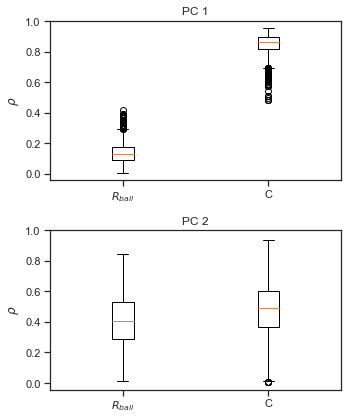

In [16]:
rho_box = SepiaPlot.rho_box_plots(model,labels=[r'$R_{ball}$','C'])

----
## Predictions of model output from the full model

First, predictions showing just the emulator response, using
SepiaEmulatorPredict

In [17]:
model.verbose=True
x_pred=data.obs_data.x
n_pred=x_pred.shape[0]
pred_samples=model.get_samples(nburn=1000,effectivesamples=True)
pred=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model)#, t_pred=t_pred)

Max effective sample size over thetas: 202
Total samples: 4000


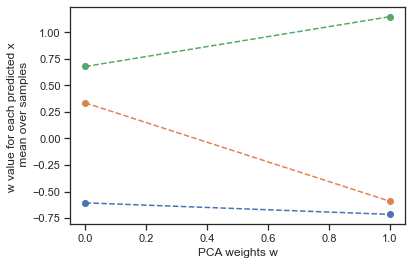

In [18]:
predw=pred.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T,'--o')
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

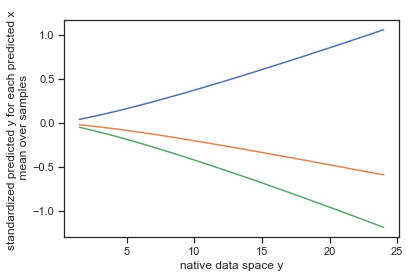

In [19]:
predystd=pred.get_y(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

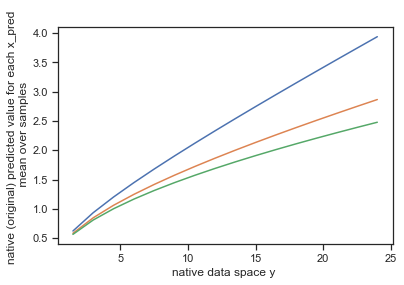

In [20]:
predy=pred.get_y()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

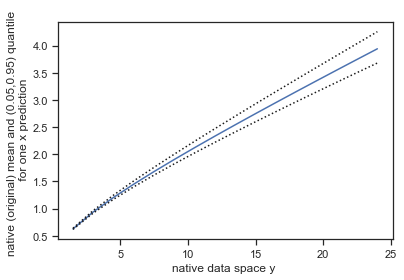

In [21]:
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,0,:],0).T)
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,0,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.show()

And below are similar predictions for the full models responses joint u and v


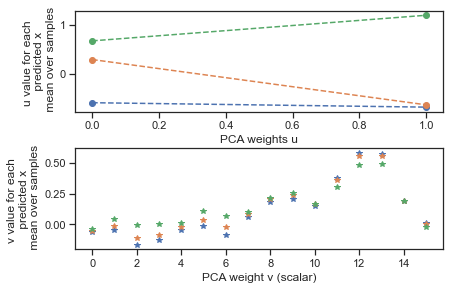

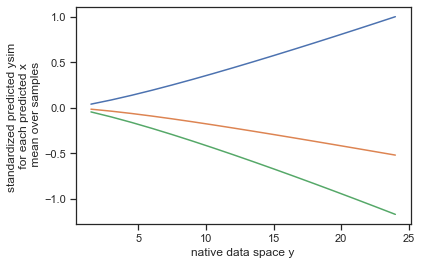

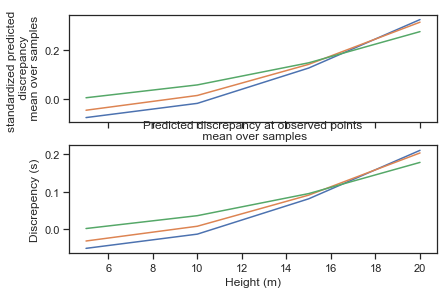

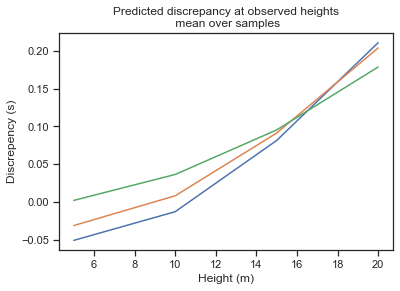

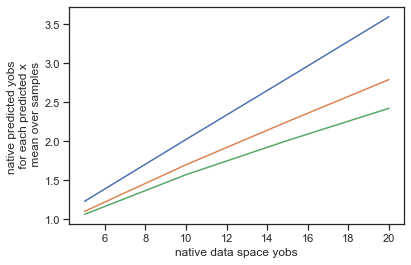

In [22]:
from sepia.SepiaPredict import SepiaFullPrediction
pred=SepiaFullPrediction(data.obs_data.x, pred_samples, model)

predu, predv = pred.get_u_v()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()
ax1.plot(np.mean(predu,0).T,'--o')
ax1.set_xlabel('PCA weights u')
ax1.set_ylabel('u value for each \n predicted x \n mean over samples')
ax2.plot(np.mean(predv,0).T,'*')
ax2.set_xlabel('PCA weight v (scalar)')
ax2.set_ylabel('v value for each \n predicted x \n mean over samples')
plt.show()

predysimstd=pred.get_ysim(std=True)
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predysimstd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted ysim \n for each predicted x \n mean over samples')
plt.show()

preddstd=pred.get_discrepancy(as_obs=True,std=True)
predd=pred.get_discrepancy(as_obs=True)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.tight_layout()
ax1.plot(model.data.obs_data.y_ind,np.mean(preddstd,0).T)
#ax1.set_xlabel('native data space y \n ($\delta$ is constant in this example)')
ax1.set_ylabel('standardized predicted \n discrepancy\n mean over samples')
ax2.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
ax2.set_xlabel('Height (m)')
ax2.set_ylabel('Discrepency (s)')
ax2.set_title('Predicted discrepancy at observed points\n mean over samples')
plt.show()

fig, ax = plt.subplots()
ax.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Discrepency (s)')
ax.set_title('Predicted discrepancy at observed heights\n mean over samples')
plt.show()

predyobs=pred.get_yobs(as_obs=True)
plt.figure()
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs,0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs \n for each predicted x \n mean over samples')
plt.show()

### Summary plot of predicted uncertainty for an observation.
The 5th prediction done corresponds to the observation in the model, with xpred=0.5.

/Users/granthutchings/opt/anaconda3/envs/sepia/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1c199a0ba8> has a label of '_' which cannot be automatically added to the legend.
  app.launch_new_instance()


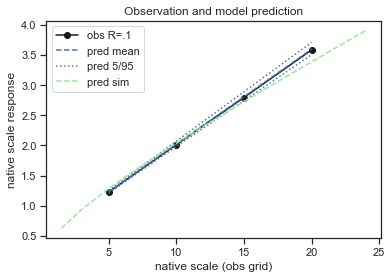

In [23]:
predyobs=pred.get_yobs(as_obs=True)
predysim=pred.get_ysim()
plt.figure()
colors = ('r','g','b')
R_idx = 0
#for i in range(model.data.obs_data.y.shape[0]):
#    plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y[i,:],color=colors[i],marker='o')
plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y[R_idx,:],c='k',marker='o')
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs[:,R_idx,:],0).T,'b--')
plt.plot(model.data.obs_data.y_ind,np.quantile(predyobs[:,R_idx,:],[0.05, 0.95],axis=0).T,'b:')
plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,R_idx,:],0).T,'--',c='lightgreen')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
#plt.legend(['obs R=.1','obs R=.2','obs R=.4','pred mean','_','pred 5/95','pred sim'])
plt.legend(['obs R=.1','pred mean','_','pred 5/95','pred sim'])
plt.show()